In [59]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

In [60]:
def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0: return 0  # colinear
    return 1 if val > 0 else 2  # horário (1) ou anti-horário (2)

def polar_angle(p0, p1):
    y_span = p1[1] - p0[1]
    x_span = p1[0] - p0[0]
    return np.arctan2(y_span, x_span)

def distance(p0, p1):
    return (p1[0] - p0[0])**2 + (p1[1] - p0[1])**2

def graham_scan(points):
    n = len(points)

    # ponto com a coordenada y mais baixa
    ymin = min(points, key=lambda x: x[1])
    min_index = points.index(ymin)
    points[0], points[min_index] = points[min_index], points[0]  # troca o ponto inicial com o primeiro ponto

    # ordena os pontos por ângulo polar e depois por distância
    pivot = points[0]
    sorted_points = sorted(points[1:], key=lambda x: (polar_angle(pivot, x), -distance(pivot, x))) # ordena por ângulo polar e depois por distância em caso de empate

    # inicializa a pilha
    stack = [pivot, sorted_points[0], sorted_points[1]]

    # processamento
    for point in sorted_points[2:]:
        # enquanto houver mudança de direção no sentido horário, remove o último ponto da pilha
        while len(stack) > 1 and orientation(stack[-2], stack[-1], point) == 1:
            stack.pop()
        stack.append(point)
    
    return stack


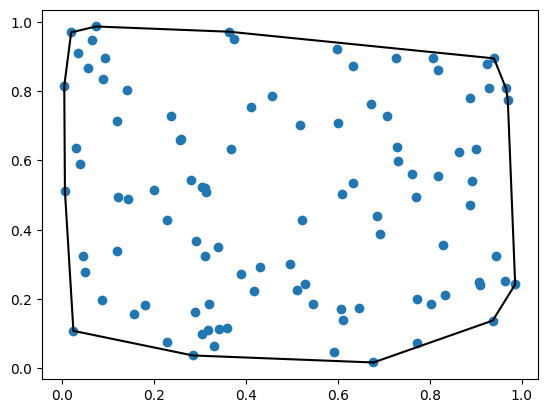

In [61]:
# gera 100 pontos 2D
np.random.seed(42)
points = np.random.rand(100, 2)
plt.scatter(points[:, 0], points[:, 1])

# calcula envoltória convexa
hull = graham_scan(points.tolist())

# plota a envoltória convexa
hull.append(hull[0])  # adiciona o primeiro ponto ao final para fechar o polígono
hull = np.array(hull)
plt.plot(hull[:, 0], hull[:, 1], 'k-')
plt.show()